# Zero-Shot Noise2Noise Experiment

[CVPR 2023: Zero-Shot Noise2Noise: Efficient Image Denoising without any Data](https://openaccess.thecvf.com/content/CVPR2023/papers/Mansour_Zero-Shot_Noise2Noise_Efficient_Image_Denoising_Without_Any_Data_CVPR_2023_paper.pdf)

Key idea: 
- the method is as simple as convolving the noisy image with two fixed kernels to create **a pair of downsampled images**. **A simple 2 layer CNN** is then trained with a **consistency loss**(regularization term) to map one downsampled image to the other.

limitation:
- This method is primarily suitable for **pixel-independent noise**, which may restrict its applicability to other types of noise or more complex scenarios. For instance, noise that is strongly correlated with signal strength like Poisson noise might not be well-suited for this method.


In [ ]:
import os
import copy
import json
import time

import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from module.models import CNN, DnCNN, UNet
# from module.datasets import Nb2NbDataset
from module.loss import SSIMLoss, SSIM_MAELoss, SSIM_MSELoss


import h5py
from tqdm.notebook import tqdm


import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

## 0. Load preprocessed data

In [ ]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poisson_0.50_batch.h5', 'r') as f:
    noisy_data = f['dataset'][...][0]
    restore_info = json.loads(f['restore_info'][()])
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)

display_image_in_detail(noisy_data[11, 38], title="prepared noisy data")

In [ ]:
#
val_tensor = torch.tensor(noisy_data, dtype=torch.float32).unsqueeze(2)
print(f"Validation tensor...{val_tensor.dtype} (shape:{val_tensor.shape}; range:[{torch.min(val_tensor)},{torch.max(val_tensor)}]; mean:{torch.mean(val_tensor)}); std:{torch.std(val_tensor)}")

## 1. Import a simple network

In [ ]:
in_chan = val_tensor.shape[2]
out_chan = 1

model = CNN(n_chan=in_chan, chan_embed=48, num_hidden_layers=3).to(device)
#model = DnCNN(in_chan, out_chan).to(device)
#model = UNet(in_chan, out_chan).to(device)

print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

summary(model, [(1, 192, 192)])

## 2. Define Method Modules



the **image pair downsampler** which outputs two downsampled images of half the spatial resolution by averaging diagonal pixels in non-overlapping patches, as shown in the below figure.

It is realised by convolving the image with the 2 fixed kernels: $k_1 = \begin{bmatrix}0 & 0.5 \\0.5 & 0\end{bmatrix}$ and $k_2 = \begin{bmatrix}0.5 & 0 \\0 & 0.5\end{bmatrix}$, where the convolution has stride=2, and is applied to each image channel separately.


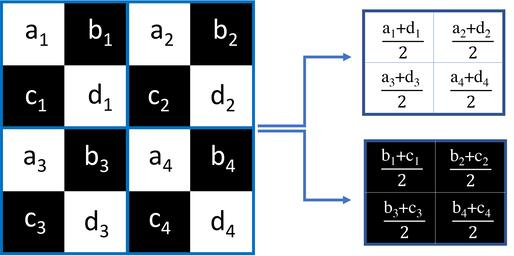

In [ ]:
# define down-sampler 
def pair_downsampler(img):
    #img has shape B C H W
    c = img.shape[1]

    filter1 = torch.FloatTensor([[[[0 ,0.5],[0.5, 0]]]]).to(img.device)
    filter1 = filter1.repeat(c,1, 1, 1)

    filter2 = torch.FloatTensor([[[[0.5 ,0],[0, 0.5]]]]).to(img.device)
    filter2 = filter2.repeat(c,1, 1, 1)

    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)

    return output1, output2

The **loss function** is the sum of a residual loss plus a consistency loss as follows:

$$     \mathcal{L}_\mathrm{res.}(\theta) =\frac{1}{2}\left( \|D_1({y}) - f_{\theta}(D_1({y})) - D_2({y})\|_2^2 + \|D_2({y}) - f_{\theta}(D_2({y})) - D_1({y})\|_2^2 \right). $$

$$     \mathcal{L}_\mathrm{cons.}(\theta) = \frac{1}{2} \left( \|f_{\theta}(D_1({y})) - D_1(f_{\theta}({y}))\|_2^2 + \|f_{\theta}(D_2({y})) - D_2(f_{\theta}({y}))\|_2^2 \right). $$

$$ \mathcal{L}(\theta) = \mathcal{L}_\mathrm{res.}(\theta) + \mathcal{L}_\mathrm{cons.}(\theta), $$

where $y$ is the noisy input image, $D$ is the image pair downsampler, and $f_\theta$ is the network.

In [ ]:
# mean square error 
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)


# loss function
def loss_func(noisy_img):
    noisy1, noisy2 = pair_downsampler(noisy_img)

    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)

    loss_res = 1/2*(mse(noisy1,pred2)+mse(noisy2,pred1))

    noisy_denoised =  noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons=1/2*(mse(pred1,denoised1) + mse(pred2,denoised2))

    loss = loss_res + loss_cons

    return loss

# 3. Example denoising

gaussian 0.50 test

| Max Epoch | Num Hidden Layers | PSNR       | SSIM   | MAE       | BRISQUE |
|-----------|-------------------|------------|--------|-----------|---------|
| 2000      | 2                 | 31.2335    | 0.5798 | 0.01108   | 155.845 |
| **2000**      | **3**                 | 31.3068    | 0.5821 | 0.01083   | 155.845 |
| 2000      | 4                 | 31.2262    | 0.5789 | 0.01076   | 155.845 |
| 4000      | 2                 | 31.1647    | 0.5727 | 0.01100   | 155.845 |
| **4000**     | **3**                 | 30.8310    | 0.5558 | 0.01137   | 155.845 |
| 4000      | 4                 | 30.9221    | 0.5568 | 0.01114   | 155.845 |
| 6000      | 2                 | 31.0026    | 0.5643 | 0.01113   | 155.845 |
| **6000**      | **3**                 | 30.7387    | 0.5444 | 0.01145   | 155.845 |
| 6000      | 4                 | 31.3118    | 0.5943 | 0.01199   | 155.845 |
| 8000      | 2                 | 30.9544    | 0.5603 | 0.01127   | 155.845 |
| 8000      | 3                 | 30.9203    | 0.5614 | 0.01132   | 155.845 |
| **8000**      | **4**                 | 30.6344    | 0.5543 | 0.01165   | 155.845 |


In [ ]:
def train(model, optimizer, noisy_img):
    loss = loss_func(noisy_img)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

def test(model, noisy_img, clean_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img),0,1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10*np.log10(1/MSE)

    return PSNR

def denoise(model, noisy_img):

    with torch.no_grad():
        pred = torch.clamp( noisy_img - model(noisy_img),0,1)

    return pred

In [ ]:
time_idx = 11
depth_idx = 38

test_noisy_img = val_tensor[time_idx, depth_idx].unsqueeze(0).to(device)

print(f"test_noisy_img: {test_noisy_img.shape} ")

## downsampling example

In [ ]:
# down-sampler example
img1, img2 = pair_downsampler(test_noisy_img)

img0 = test_noisy_img.cpu().squeeze(0).permute(1,2,0)
img1 = img1.cpu().squeeze(0).permute(1,2,0)
img2 = img2.cpu().squeeze(0).permute(1,2,0)

fig, ax = plt.subplots(1, 3,figsize=(15, 15))

ax[0].imshow(img0, cmap='hot')
ax[0].set_title('Noisy Img')

ax[1].imshow(img1, cmap='hot')
ax[1].set_title('First downsampled')

ax[2].imshow(img2, cmap='hot')
ax[2].set_title('Second downsampled')

In [ ]:
max_epoch = 4000     # training epochs
lr = 0.001           # learning rate
step_size = 1500     # number of epochs at which learning rate decays
gamma = 0.7          # factor by which learning rate decays

#
model = CNN(n_chan=val_tensor.shape[2], chan_embed=48, num_hidden_layers=3).to(device)
print("The number of parameters of the network is: ",  sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#
pbar = tqdm(range(max_epoch))
for epoch in pbar:
    loss = train(model, optimizer, test_noisy_img)
    scheduler.step()
    pbar.set_description(f"Epoch {epoch+1}, Loss: {loss:.4f}")

In [ ]:
# prediction
test_denoised_img = denoise(model, test_noisy_img)

#
noisy = test_noisy_img.cpu().squeeze(0).permute(1,2,0).numpy()
denoised = test_denoised_img.cpu().squeeze(0).permute(1,2,0).numpy()

#
print(f"noisy: {noisy.shape} range:({np.min(noisy)}, {np.max(noisy)}); mean:{np.mean(noisy)}; std:{np.std(noisy)}")
print(f"denoised: {denoised.shape} range:({np.min(denoised)}, {np.max(denoised)}); mean:{np.mean(denoised)}; std:{np.std(denoised)}")

#
data_range_noisy = np.max(noisy) - np.min(noisy)
data_range_denoised = np.max(denoised) - np.min(denoised)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(np.squeeze(noisy), np.squeeze(denoised), data_range=data_range)

psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan

print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

 
# 
fig, ax = plt.subplots(1, 3,figsize=(15, 15))
 
ax[0].imshow(noisy, cmap='hot')
ax[0].set_title('Noisy Img')


ax[1].imshow(denoised, cmap='hot')
ax[1].set_title('Denoised Img')

ax[2].imshow(noisy - denoised, cmap='hot')
ax[2].set_title('diff')

# 4. Process denoising

In [ ]:
# hyperparameters
max_epoch = 4000     # training epochs
lr = 0.001           # learning rate
step_size = 1500     # number of epochs at which learning rate decays
gamma = 0.7          # factor by which learning rate decays


# process denoising
total_iterations = val_tensor.shape[0] * val_tensor.shape[1]
pbar = tqdm(total=total_iterations, desc='Processing', ncols=total_iterations)

denoised_tensor = torch.zeros_like(val_tensor).to(device) # Initialize the tensor to store denoised images
start_time = time.time()
for i in range(val_tensor.shape[0]):
    for j in range(val_tensor.shape[1]):
        # reset training modules 
        model = CNN(n_chan=val_tensor.shape[2], chan_embed=48, num_hidden_layers=3).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        # take out 2D image
        sub_tensor = val_tensor[i, j].unsqueeze(0).to(device)
        # zero-shot denosing
        for epoch in range(max_epoch):
            loss = train(model, optimizer, sub_tensor)
            scheduler.step()
            pbar.set_description(f"Epoch {epoch+1}, Loss: {loss:.6f}")
                
        denoised_sub_tensor = denoise(model, sub_tensor)
        # place back
        denoised_tensor[i, j] = denoised_sub_tensor.squeeze(0)
        pbar.update(1)

end_time = time.time()
pbar.close()

print(f"Complete.....Running time: {end_time-start_time} seconds")

denoised_data = denoised_tensor.cpu().squeeze(2).numpy() # convert denoised tensor into ndarray 
print(f"denoised_data: {denoised_data.shape} range:({np.min(denoised_data)},{np.max(denoised_data)}); mean:{np.mean(denoised_data)}; std:{np.std(denoised_data)}")

# 5. Evaluation

## visuzlie check denoised result

In [ ]:
# visualize check
time_idx = 11
depth_idx = 38

#
noisy = noisy_data[time_idx, depth_idx]
denoised = denoised_data[time_idx, depth_idx]

#
data_range_noisy = np.max(noisy) - np.min(noisy)
data_range_denoised = np.max(denoised) - np.min(denoised)
data_range = max(data_range_noisy, data_range_denoised)
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, noisy_data, data_range=data_range)
psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

#
display_image_in_detail(noisy, title="example noisy")
display_image_in_detail(denoised, title="example denoised")
display_image_in_detail(noisy - denoised, title="diff")


# fig, ax = plt.subplots(1, 3,figsize=(15, 15))
 
# ax[0].imshow(noisy, cmap='hot')
# ax[0].set_title('Noisy Img')


# ax[1].imshow(denoised, cmap='hot')
# ax[1].set_title('Denoised Img')

# ax[2].imshow(noisy - denoised, cmap='hot')
# ax[2].set_title('diff')

## calcualte metrics

In [ ]:
# metrics calculation
print(f"noisy_data: {noisy_data.shape} range:({np.min(noisy_data)}, {np.max(noisy_data)}; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")
print(f"denoised_data: {denoised_data.shape} range:({np.min(denoised_data)}, {np.max(denoised_data)}; mean:{np.mean(denoised_data)}); std:{np.std(denoised_data)}")

#
data_range_noisy = np.max(noisy_data) - np.min(noisy_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)
psnr_values, ssim_values, mae_values, brisque_values = calculate_metrics(denoised_data, noisy_data, data_range=data_range)
psnr_values[np.isinf(psnr_values)] = np.nan # set inf value to nan
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}; BRISQUE: {np.nanmean(brisque_values)}")

# 6.Save denormalized denoised data into 16-bit DICOM files

In [ ]:
# denormalized denoised data
restored_data = restore_data(denoised_data, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")
display_image_in_detail(restored_data[11, 38], title="restored denoised result")

In [ ]:
# save denormalized denoised data as 16-bit gray-scale .DICOM files
origin_dicom_folder = './dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/ZS-N2N/PT_20p 150_120 OSEM_poisson_0.50'

save_4d_dicom(origin_dicom_folder, restored_data, output_folder)